# VQE H3 e H3+


### Note:
* Non imposto esplicitamente lo spin... cosa ne fa?
* Uso la base sto3g, ma potrei anche cambiarla magari
* Uso un operatore fermionico, ma non so bene cosa sia (così come anzhe le Z2Summetries)
* Su wikipedia vedo una distanza di 0.9 A, io ne calcolo una minima di 1
* Qubit mapping:
    * Parity
    * Jordan Wigner
    * Altro

In [283]:
from qiskit import Aer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry import QiskitChemistryError
from qiskit.chemistry.applications import MolecularGroundStateEnergy
from qiskit.chemistry.algorithms import ground_state_solvers
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.core import QubitMappingType
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

In [284]:
# Ottengo dei warnings perchè uso deprecated functions, così li evito un po' bruscamente
import warnings
warnings.filterwarnings("ignore")

In [285]:
#charge 0 e spin 1 -> H3
#charge 1 e spin 0 -> H3+

def get_driver(dist):
    charge = 1
    spin = 0
    alt=np.sqrt(dist**2 - (dist/2)**2)
    driver = PySCFDriver(atom="H .0 .0 .0; H .0 .0 " + str(dist) + "; H .0 " + str(alt) + " " + str(dist/2),
                         unit=UnitsType.ANGSTROM, spin = spin,
                         charge=charge, basis='sto3g')
    return driver

Restituisce vqe, ovvero? Da analizzare per bene

In [288]:
def get_qubit_op(dist):
    driver = get_driver(dist)
    molecule = driver.run()
    
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp = ferOp.mapping(map_type='jordan_wigner')
    shift =  repulsion_energy
    return qubitOp
    #return qubitOp, num_particles, num_spin_orbitals, shift

In [289]:
def cb_create_solver(num_particles, num_orbitals,
                        qubit_mapping, two_qubit_reduction, z2_symmetries):
    initial_state = HartreeFock(num_orbitals, num_particles, qubit_mapping,
                                two_qubit_reduction, z2_symmetries.sq_list)
    var_form = UCCSD(num_orbitals=num_orbitals,
                        num_particles=num_particles,
                        initial_state=initial_state,
                        qubit_mapping=qubit_mapping,
                        two_qubit_reduction=two_qubit_reduction,
                        z2_symmetries=z2_symmetries)
    #print(var_form.num_qubits) # in questo momento la varform usa 6 qubits
    vqe = VQE(operator = get_qubit_op(dist), 
              var_form=var_form, optimizer=SLSQP(maxiter=500), include_custom=True)
    #vqe = VQE(var_form=var_form, optimizer=SLSQP(maxiter=500), include_custom=True)
    vqe.quantum_instance = Aer.get_backend('qasm_simulator')
    return vqe

In [292]:
distances = np.arange(1.29, 1.3, 0.1)
vqe_energies = []
min = 0.0
dismin = 0.0

for dist in distances:
    print("Calcolo distanza: "+str(dist))
    driver = get_driver(dist)
    mgse = MolecularGroundStateEnergy(driver, 
                                  qubit_mapping=QubitMappingType.JORDAN_WIGNER,
                                  two_qubit_reduction=False, freeze_core=False,
                                  z2symmetry_reduction=None)
    try:
        result = mgse.compute_energy(cb_create_solver)
        vqe_energies.append(result.energy)
        if result.energy < min:
            min = result.energy
            dismin = dist
            print("\tEnergia: " +str(min))
    except:
        print("errore")
        vqe_energies.append(min)

print("Energia minima a " + str(dismin) + " A: " + str(min) + " eV")

Calcolo distanza: 1.29
	Energia: -1.226313897579335
Energia minima a 1.29 A: -1.226313897579335 eV


Inizialmente avevo anche una soluzione con il numpy eigensolver, ma non a bene
https://github.com/Qiskit/qiskit-aqua/issues/1162
Hi, when the 2nd quantized Hamiltonian is built out, since it has one and two- body creation and annihilation operators in its formation, we end up with states in the Hamiltonian for every possible particle configuration. The lowest eigenvalue in that Hamiltonian, ends up being the state with those atoms where the particle configuration (from none, to fully occupied) gives that lowest energy - this may NOT be the configuration you have entered. The NumPyEigensolver just gives the lowest energy period.

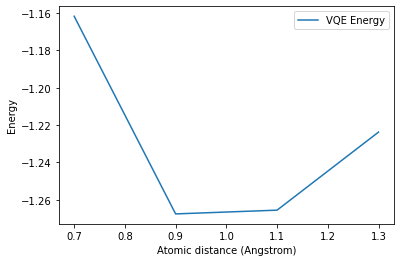

In [287]:
#plt.plot(distances, exact_energies, label="Numpy Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

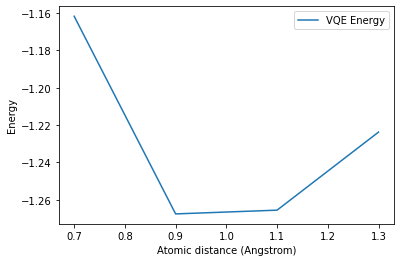

In [291]:
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()